# 01. Líbrerías y Datos

In [1]:
import pandas as pd
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import scipy
from fitter import Fitter
import pmdarima

In [2]:
#Get stock data from google

df= yf.download('AAPL', start='2020-03-31', end='2023-03-31')

[*********************100%%**********************]  1 of 1 completed


In [3]:
px.line(df, y=["Close"], title="AAPL stock price")

In [4]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.update_layout(xaxis_rangeslider_visible=False, title='AAPL Stock Price', xaxis_title='Date', yaxis_title='Price')
#add title

fig.show()

# 02. Movimiento Browniano

In [5]:
df["returns"]= np.log(df.Close) - np.log(df.Close.shift(1))
df

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2020-03-31,63.900002,65.622498,63.000000,63.572498,62.002243,197002000,NaN
2020-04-01,61.625000,62.180000,59.782501,60.227501,58.739864,176218400,-0.054052
2020-04-02,60.084999,61.287498,59.224998,61.232498,59.720028,165934000,0.016549
2020-04-03,60.700001,61.424999,59.742500,60.352501,58.861774,129880000,-0.014476
2020-04-06,62.724998,65.777496,62.345001,65.617500,63.996723,201820400,0.083640
...,...,...,...,...,...,...,...
2023-03-24,158.860001,160.339996,157.850006,160.250000,159.399170,59196500,0.008271
2023-03-27,159.940002,160.770004,157.869995,158.279999,157.439636,52390300,-0.012369
2023-03-28,157.970001,158.490005,155.979996,157.649994,156.812958,45992200,-0.003988


In [6]:
train, test = pmdarima.model_selection.train_test_split(df.Close.dropna(), train_size = 0.8)
training, testing = pmdarima.model_selection.train_test_split(df.returns.dropna(), train_size = 0.8)

2024-04-16 06:33:29.700 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 120 seconds)
2024-04-16 06:33:30.320 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=8914.111215)
2024-04-16 06:33:30.989 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=6141.397291)
2024-04-16 06:33:31.129 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=8688.976007)
2024-04-16 06:33:31.242 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=807.094227)
2024-04-16 06:33:31.261 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=5283.259316)
2024-04-16 06:33:31.709 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=680.418735)
2024-04-16 06:33:32.388 | INFO     | fitter.fitter:_fit_single_di

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gennorm,487.889570,-31.230093,-18.019370,inf,0.031896,0.559553
hypsecant,514.738232,-55.879132,-47.071984,inf,0.025465,0.818607
tukeylambda,524.004332,-39.419082,-26.208360,inf,0.022281,0.918549
dweibull,524.450348,-49.754443,-36.543720,inf,0.038481,0.324481
norminvgauss,529.982908,-30.774498,-13.160202,inf,0.024836,0.841006


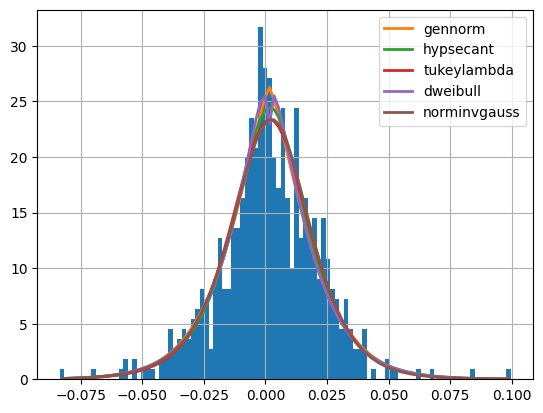

In [7]:
f = Fitter(training, timeout = 120)
f.fit()
f.summary()

In [8]:
f.get_best(method = "bic")

{'uniform': {'loc': -0.08344776435769319, 'scale': 0.18301127793869032}}

In [9]:
def GBMsimulatorUniVar(So, mu, sigma, T, N):
    dim = np.size(So)
    S = np.zeros([T + 1, int(N)])
    S[0, :] = So
    for t in range(1, int(T) + 1):
        for i in range(0, int(N)):    
            drift = (mu - 0.5 * sigma**2)
            Z = scipy.stats.laplace.rvs()
            diffusion = sigma*Z
            S[t][i] = S[t - 1][i]*np.exp(drift + diffusion)
    return S[1:]

In [10]:
prices = GBMsimulatorUniVar(So = df.Close.iloc[len(training)], mu = training.mean(), sigma = training.std(), T = len(test), N = 1000)
newpreds = pd.DataFrame(prices).mean(axis = 1)

c:\Users\Hp\Documents\GitHub\Proyectos-de-Ingenieria-Matematica\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.

c:\Users\Hp\Documents\GitHub\Proyectos-de-Ingenieria-Matematica\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



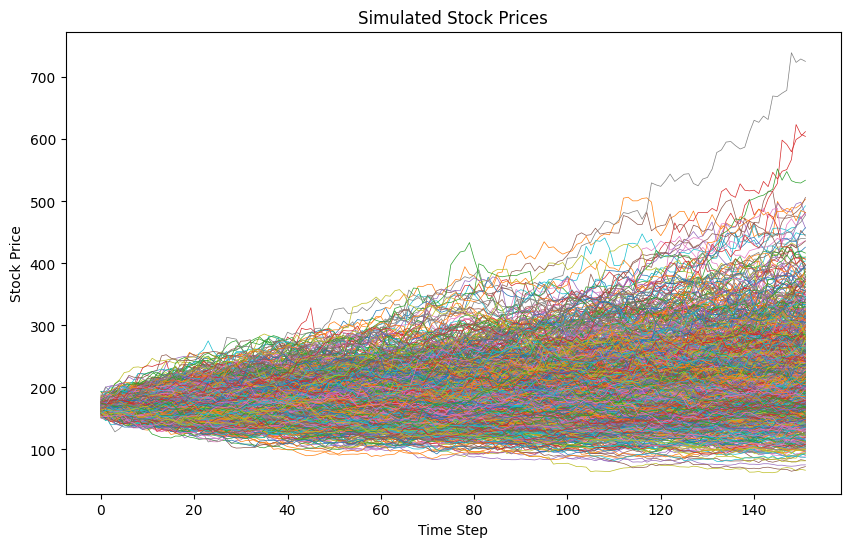

In [13]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over the columns of the prices array
for i in range(prices.shape[1]):
    # Plot each column as a separate line
    plt.plot(prices[:, i], linewidth=0.5)

# Add title and labels
plt.title('Simulated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

# Show the figure
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(newpreds, test.dropna())

c:\Users\Hp\Documents\GitHub\Proyectos-de-Ingenieria-Matematica\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.

c:\Users\Hp\Documents\GitHub\Proyectos-de-Ingenieria-Matematica\.venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



0.23524759169906978

In [15]:
# Create a new figure
fig = go.Figure()

# Add a line for the train data
fig.add_trace(go.Scatter(x=np.arange(len(train)), y=train, mode='lines', name='Train', line=dict(color='blue')))

# Add a line for the test data
fig.add_trace(go.Scatter(x=np.arange(len(train), len(train) + len(test)), y=test, mode='lines', name='Test', line=dict(color='blue')))

# Add a line for the predictions
fig.add_trace(go.Scatter(x=np.arange(len(train), len(train) + len(test)), y=np.array(newpreds), mode='lines', name='Predictions', line=dict(color='green')))

# Show the figure
fig.show()